In [38]:
from os import path, makedirs, walk,listdir, remove
import pandas as pd
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Rescaling,RandomFlip, RandomRotation, RandomZoom, RandomContrast
from keras.backend import clear_session
from keras.utils import image_dataset_from_directory, split_dataset
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from tensorflow.data import AUTOTUNE
from keras.metrics import BinaryAccuracy, Precision, Recall, F1Score, TrueNegatives, TruePositives, FalseNegatives, FalsePositives
from keras.callbacks import EarlyStopping
from keras.regularizers import L2
from random import choice

In [39]:
DATASET_NAMES = ('train','valid','test')
CLASS_DIRECTORY_NAMES = ('class_fracture','class_no_fracture')
DATASET_DIRECTORY = 'dataset'
AUGMENTED_DATASET_DIRECTORY ='augmented_images'
TOP_DIRECTORY_CLASSIFIFICATIONS = path.join(DATASET_DIRECTORY ,'categorised_images')
TOP_DIRECTORY_AUGMENTED_CLASSIFIFICATIONS = path.join(AUGMENTED_DATASET_DIRECTORY ,'categorised_images')
AUGMENTATION_LAYERS = [RandomFlip("horizontal"), RandomRotation(0.2), RandomZoom(0.2), RandomContrast(0.2)]
NUMBER_OF_AUGMENTATIONS = 3
#Hyperparameters
OPTIMIZER = Adam
LEARNING_RATE = 0.0001
LOSS_FUNCTION = BinaryCrossentropy
METRICS = [BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), F1Score(name='f1'), TrueNegatives(name='tn'), TruePositives(name='tp'), FalseNegatives(name='fn'), FalsePositives(name='fp')]
EPOCHS = 50
BATCH_SIZE = 10
VERBOSE = 1
REGULARIZER=None
REGULARIZATION_FACTOR = 0.01
VALIDATION_SPLIT = 0.2
INPUT_SHAPE = (256,256,1)

In [3]:
def categorise_images(a_dataset_name):
    #creates a directory structure  like: images/
    #                                       class0/*.jpg
    #                                       class1/*.jpg
    #and copies the images into either leaf directory depending on their class label
    #this puts the data into a format that keras can load into a dataset

    fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, a_dataset_name,CLASS_DIRECTORY_NAMES[0])
    print('fracture_directory', fracture_directory)
    no_fracture_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS,a_dataset_name,CLASS_DIRECTORY_NAMES[-1])
    print('no_fracture_directory', no_fracture_directory)

    if path.exists(fracture_directory) == False:  
        makedirs(fracture_directory) 
    if path.exists(no_fracture_directory) == False:  
        makedirs(no_fracture_directory) 

    #read labels into pandas df
    csv_filepath = path.join(DATASET_DIRECTORY, a_dataset_name, 'labels/labels.csv')
    print('csv_filepath', csv_filepath)
    df = pd.read_csv(path.join(csv_filepath))
    df = df.set_index('filename')

    #walk through files and copy file to relevant directory
    images_dir = path.join(DATASET_DIRECTORY,a_dataset_name,'images')
    print('images_dir', images_dir)
    filenames = []
    for (dirpath, dirnames, filenames) in walk(images_dir):
        filenames.extend(filenames)
 
    for filename in filenames:
        #ignore mac os system file
        if filename.endswith('.DS_Store'):
            pass
        elif df.loc[filename]['target'] == 1:
            destination = path.join(fracture_directory, filename)
        else:
            destination = path.join(no_fracture_directory, filename)
        source = path.join(images_dir, filename)
        copyfile(source, destination)

In [ ]:
for dataset_name in DATASET_NAMES:
    categorise_images(dataset_name)

In [40]:
#remove any non-jpg files in the directories
def find_and_remove_non_jpg_files(a_folder_path):
    #removes any non-jpg files in the provided directory
    num_skipped = 0
    for fname in listdir(a_folder_path):
        fpath = path.join(a_folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            print('removing non-image file: ' + fpath)
            remove(fpath)

    print(f"Deleted {num_skipped} files.")

In [41]:
#remove any non-processable files from the image directories
folders_checked = 0
for dataset_name in DATASET_NAMES:
    for class_dir_name in CLASS_DIRECTORY_NAMES:
        for top_directory in (TOP_DIRECTORY_CLASSIFIFICATIONS, TOP_DIRECTORY_AUGMENTED_CLASSIFIFICATIONS):
            folder_path = path.join(top_directory, dataset_name,class_dir_name)
            print('checking folder: '+folder_path)
            find_and_remove_non_jpg_files(folder_path)
            folders_checked +=1
print('checked', folders_checked, 'folders')

checking folder: dataset/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/train/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/train/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/valid/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/valid/class_no_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/valid/class_no_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_fracture
Deleted 0 files.
checking folder: augmented_images/categorised_images/test/class_fracture
Deleted 0 files.
checking folder: dataset/categorised_images/test/class_no_fracture
Deleted 0 files.
checking folder: augmented_images/categor

In [6]:
def load_images(a_dataset_directory):
        
    return image_dataset_from_directory(
        directory=a_dataset_directory,
        labels='inferred',
        label_mode="binary",
        color_mode="grayscale",
        batch_size=BATCH_SIZE,
        image_size=(256, 256),
        shuffle=False,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation="bilinear",
        follow_links=False
    )  

In [42]:
#Load the images into datasets
#load the datasets
train_ds_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, 'train')
valid_ds_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, 'valid')
test_ds_directory = path.join(TOP_DIRECTORY_CLASSIFIFICATIONS, 'test')
train_ds = load_images(train_ds_directory)
valid_ds= load_images(valid_ds_directory)
test_ds= load_images(test_ds_directory)

Found 3630 files belonging to 2 classes.
Found 348 files belonging to 2 classes.
Found 169 files belonging to 2 classes.


In [43]:
def data_augmentation(image):
    #function for performing image augmentation
    for layer in AUGMENTATION_LAYERS:
        image = layer(image)
    return image

In [26]:
#create augmentations for the training dataset
train_images = []
train_labels = []
for images, labels in train_ds.as_numpy_iterator():
    for index, image in enumerate(images):
        #add the original image and label
        label = labels[index]
        train_images.append(image)
        train_labels.append(label)
        #add the augmented images and labels
        for each in range(NUMBER_OF_AUGMENTATIONS):
            train_images.append(data_augmentation(image))
            train_labels.append(label)
train_images = np.array(train_images)
train_labels = np.array(train_labels)

#define the test images and labels
test_images = []
test_labels = []
for images, labels in test_ds.as_numpy_iterator():
    test_images.extend(images)
    test_labels.extend(labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

#define the validation images and labels
valid_images = []
valid_labels = []
for images, labels in valid_ds.as_numpy_iterator():
    valid_images.extend(images)
    valid_labels.extend(labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

2024-03-25 16:08:21.600736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 16:08:26.983804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-25 16:08:27.042107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
for images, lables in train_ds.take(1):
    for index, image in enumerate(images):
        plt.imshow(image)
        label = lables[index]
        plt.title('label = ' + str(int(label)))
        plt.show()

In [ ]:
for index, image, in enumerate(train_images[:100]):
    plt.imshow(image)
    label = train_labels[index]
    plt.title('label = ' + str(int(label)))
    plt.show()

In [27]:
X_train = train_images
y_train = train_labels
X_valid = valid_images
y_valid = valid_labels
X_test = test_images
y_test = test_labels
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_valid', X_valid.shape)
print('y_valid', y_valid.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (14520, 256, 256, 1)
y_train (14520, 1)
X_valid (348, 256, 256, 1)
y_valid (348, 1)
X_test (169, 256, 256, 1)
y_test (169, 1)


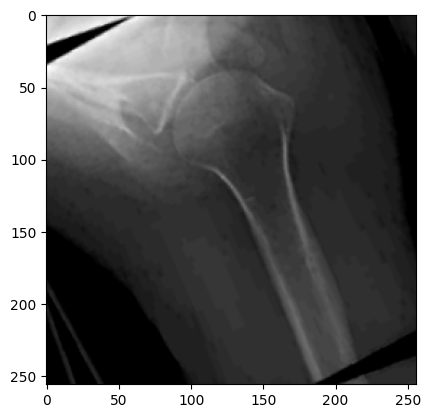

In [28]:
random_training_image = choice(X_train)
plt.imshow(random_training_image, cmap='gray')
plt.show()

In [29]:
def create_model(input_shape):

    #create a Sequential  model
    model = Sequential()

    #Add the layers
    model.add(Input(input_shape))
    model.add(Rescaling(1.0 / 255))
    #Add 2 convolutional layers paired with max pooling layers
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'valid', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    #Flatten the output so that it can be processed as a Vector by the subsequent Dense layer
    model.add(Flatten())
    #if using a regularizer, instantiate it with the regularization factor
    if REGULARIZER is not None:
        the_regularizer = REGULARIZER(REGULARIZATION_FACTOR)
    else:
        the_regularizer = REGULARIZER
    #add a fully connected layer with  256 neurons and a relu activation function outut shape = 64
    model.add(Dense(256, kernel_regularizer=the_regularizer, activation='relu'))
    #add output layer with a single neuron and a sigmoind activation to represent the binary classification
    model.add(Dense(1, kernel_regularizer=REGULARIZER, activation='sigmoid'))

    return model

In [30]:
model = create_model(INPUT_SHAPE)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 230400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    58,982,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,352,577 (226.41 MB)

 Trainable params: 59,352,577 (226.41 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
def train_model(X_train, y_train, X_valid, y_valid):
    
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=5, verbose=VERBOSE, restore_best_weights=True)]
    
    model = create_model(INPUT_SHAPE)
    model.compile(optimizer=OPTIMIZER(LEARNING_RATE), loss=LOSS_FUNCTION(), metrics=METRICS)
    model_history = model.fit(
                            X_train, y_train,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_data=(X_valid, y_valid),
                            verbose=VERBOSE,
                            callbacks=callbacks)
    clear_session()

    return (model, model_history)

In [52]:
model, model_history = train_model(X_train, y_train, X_valid, y_valid)

Epoch 1/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 261s 177ms/step - accuracy: 0.5922 - f1: 0.6085 - fn: 3029.7129 - fp: 2532.2327 - loss: 0.6901 - precision: 0.5410 - recall: 0.4714 - tn: 4939.1533 - tp: 2948.8940 - val_accuracy: 0.4971 - val_f1: 0.6692 - val_fn: 97.0000 - val_fp: 78.0000 - val_loss: 0.7213 - val_precision: 0.5000 - val_recall: 0.4457 - val_tn: 95.0000 - val_tp: 78.0000
Epoch 2/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 255s 176ms/step - accuracy: 0.6022 - f1: 0.6666 - fn: 1616.1211 - fp: 1277.8417 - loss: 0.6533 - precision: 0.6152 - recall: 0.5469 - tn: 2334.0000 - tp: 2042.0303 - val_accuracy: 0.5460 - val_f1: 0.6692 - val_fn: 67.0000 - val_fp: 91.0000 - val_loss: 0.7348 - val_precision: 0.5427 - val_recall: 0.6171 - val_tn: 82.0000 - val_tp: 108.0000
Epoch 3/50
1452/1452 ━━━━━━━━━━━━━━━━━━━━ 254s 175ms/step - accuracy: 0.6922 - f1: 0.6618 - fn: 1213.5768 - fp: 1014.0626 - loss: 0.5586 - precision: 0.7005 - recall: 0.6601 - tn: 2623.0681 - tp: 2419.2856 - val_accuracy: 0.6006 - val_

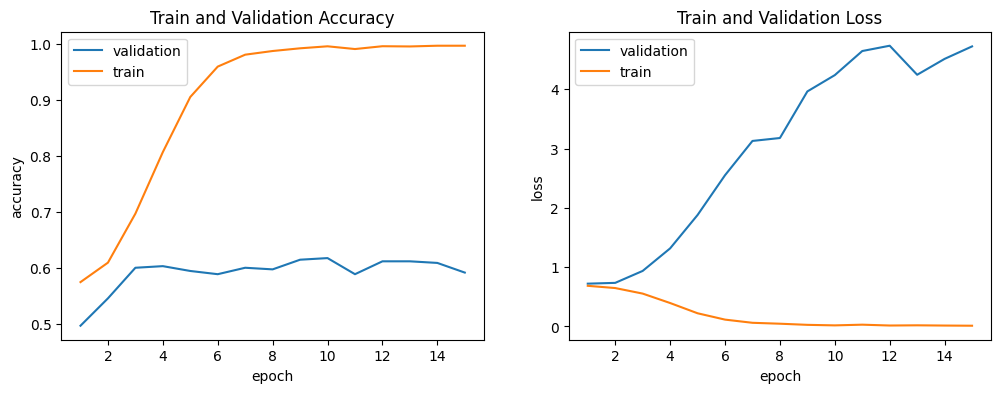

In [53]:
#plot the model accuracy and loss
epochs = len(model_history.history['accuracy'])
train_accuracy = model_history.history['accuracy']
valid_accuracy = model_history.history['val_accuracy']
train_loss = model_history.history['loss']
valid_loss = model_history.history['val_loss']

fig, (accuracy, loss) = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(12,4 )
accuracy.plot(range(1, epochs+1), valid_accuracy) 
accuracy.plot(range(1, epochs+1), train_accuracy)  
accuracy.set_ylabel('accuracy')
accuracy.set_xlabel('epoch')
accuracy.legend(['validation','train'], loc='upper left')
accuracy.set_title('Train and Validation Accuracy')

loss.plot(range(1, epochs+1), valid_loss)
loss.plot(range(1, epochs+1), train_loss)
loss.set_ylabel('loss')
loss.set_xlabel('epoch')
loss.legend(['validation', 'train'], loc='upper left')
loss.set_title('Train and Validation Loss')

plt.show()

In [54]:
results  = model.evaluate(X_test, y_test)
print('accuracy', results[1])
print('loss', results[0])
print('precision', results[2])
print('recall', results[3])
print('f1', results[4])
print('tn', results[5])
print('tp', results[6])
print('fn', results[7])
print('fp', results[8])

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.5368 - f1: 0.3940 - fn: 20.5714 - fp: 33.8571 - loss: 4.5700 - precision: 0.3013 - recall: 0.3710 - tn: 39.1429 - tp: 23.2857
accuracy 0.5325443744659424
loss 4.432675838470459
precision 0.6721310615539551
recall 40.0
f1 39.0
tn 0.5411764979362488
tp 0.5348837375640869
fn 44.0
fp 46.0


In [55]:
predictions = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


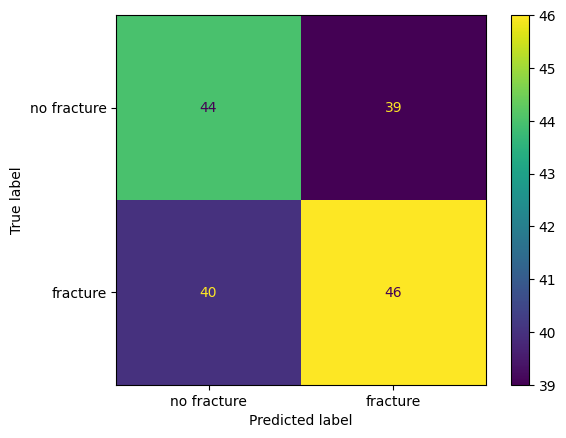

In [56]:
binary_predictions = np.where(predictions > 0.5, 1, 0)
binary_predictions
matrix = confusion_matrix(y_test, binary_predictions)
ConfusionMatrixDisplay(matrix, display_labels=['no fracture', 'fracture']).plot()

In [37]:
import datetime
print("Last modified: ", datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S") + "\n")

Last modified:  25/03/2024 18:51:19
